1). Обучить алгоритмы LightGBM и XGBoost, получить OOF прогнозы, оценить корреляцию прогнозов на обучающей выборке. Применить модели на тестовую выборку и оценить корреляцию.
<br>2). Усреднить прогнозы с помощью арифмитического среднего, геометрического среднего и усреднить ранги, сделать выводы о качестве отдельных моделей и о качестве комбинации.
<br>3). Обучить CatBoost, получить OOF прогнозы и выполнить задание 1 для трех моделей.
<br>4). Выполнить задание 2 для трех моделей.
<br>5). (опция) Объединить OOF-прогнозы для трех моделей и обучить алгоритм Логистической регрессии (и любой другой, на ваше усмотрение). Сделать выводы о достигаемом качестве, сравнить достигаемое качество с качеством отдельных моделей и моделей, полученных в п.2 и п.4.
<br>6). (опция) Обучить алгоритмRandomForest (желательно подтюнить параметры) и добавить к построенным ранее моделям. Выполнить задание 5.

In [1]:
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import xgboost as xgb

from scipy.stats.mstats import gmean
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

from pprint import pprint
from tqdm import tqdm
from typing import List, Optional, Tuple

from bayes_opt import BayesianOptimization
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from IPython.display import clear_output, display

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
sns.set()

Функции с вебинара:

In [2]:
def get_input(data_path: str) -> pd.DataFrame:
    """
    Считывание данных и вывод основной информации о наборе данных.

    Parameters
    ----------
    data_path: str
        Название файла.

    Returns
    -------
    data: pandas.core.frame.DataFrame
        Загруженный набор данных в pandas.DataFrame

    """
    base_path = "geekbrains-competitive-data-analysis"
    data = pd.read_csv(f"{base_path}/{data_path}")
    data.columns = [col.lower() for col in data.columns]
    print(f"{data_path}: shape = {data.shape[0]} rows, {data.shape[1]} cols")

    return data


def create_client_profile_features(X: pd.DataFrame, copy: bool = True) -> pd.DataFrame:
    """
    Создание признаков на основе профиля клиентов.

    Parameters
    ----------
    X: pandas.core.frame.DataFrame
        Матрица признаков с исходным профилем клиента.

    copy: bool, optional, default = True
        Флаг использования копии датафрейма X.
        Опциональный параметр, по умолчанию, равен True.

    Returns
    -------
    X_transformed: pandas.core.frame.DataFrame
        Расширенная матрица признаков с профилем клиентов.

    """
    if copy:
        X = X.copy()

    X["days_on_last_job"] = X["days_on_last_job"].replace(365243, np.nan)
    bki_flags = [flag for flag in X.columns if "amt_req_credit_bureau" in flag]
    X["bki_requests_count"] = X[bki_flags].sum(axis=1)
    X["bki_kurtosis"] = X[bki_flags].kurtosis(axis=1)

    X["external_scoring_prod"] = X["external_scoring_rating_1"] * X["external_scoring_rating_2"] * X["external_scoring_rating_3"]
    X["external_scoring_weighted"] = X.external_scoring_rating_1 * 2 + X.external_scoring_rating_2 * 1 + X.external_scoring_rating_3 * 3

    for function_name in ["min", "max", "mean", "nanmedian", "var"]:
        feature_name = "external_scoring_rating_{}".format(function_name)
        X[feature_name] = eval("np.{}".format(function_name))(
            X[["external_scoring_rating_1", "external_scoring_rating_2", "external_scoring_rating_3"]], axis=1
        )

    # Отношение между основными фин. показателями
    X['ratio_credit_to_annuity'] = X['amount_credit'] / X['amount_annuity']
    X["ratio_annuity_to_salary"] = X['amount_annuity'] / X['total_salary']
    X['ratio_credit_to_salary'] = X['amount_credit'] / X['total_salary']
    #X["total_salary_net"] = X["total_salary"] - X["amount_annuity"]

    # Отношение фин. показателей к возрасту и временным фичам
    X["ratio_annuity_to_age"] = X["amount_annuity"] / X["age"]
    X["ratio_credit_to_age"] = X["amount_credit"] / X["age"]
    X["ratio_salary_to_age"] = X["total_salary"] / X["age"]
    X["ratio_salary_to_experience"] = X["total_salary"] / X["days_on_last_job"]
    X["ratio_credit_to_experience"] = X["amount_credit"] / X["days_on_last_job"]
    X["ratio_annuity_to_experience"] = X["amount_annuity"] / X["days_on_last_job"]

    # Отношение врменных признаков
    X["ratio_age_to_experience"] = X["age"] / X["days_on_last_job"]
    X["ratio_salary_to_region_population"] = X["total_salary"] * X["region_population"]
    X["ratio_car_to_experience"] = X["own_car_age"] / X["days_on_last_job"]
    X["ratio_car_to_age"] = X["own_car_age"] / X["age"]

    # Произведение фин. показателей кредита на вероятность дефолта
    # Такая штука называется математическим ожиданием дефолта или ожидаемыми потерями
    X["expected_total_loss_1"] = X["external_scoring_rating_1"] * X["amount_credit"]
    X["expected_total_loss_2"] = X["external_scoring_rating_2"] * X["amount_credit"]
    X["expected_total_loss_3"] = X["external_scoring_rating_3"] * X["amount_credit"]
    X["expected_monthly_loss_1"] = X["external_scoring_rating_1"] * X["amount_annuity"]
    X["expected_monthly_loss_2"] = X["external_scoring_rating_2"] * X["amount_annuity"]
    X["expected_monthly_loss_3"] = X["external_scoring_rating_3"] * X["amount_annuity"]

    return X

Константы:

In [3]:
EARLY_STOPPING_ROUNDS = 25
N_ITERATIONS = 1000
VERBOSE = 100
N_SPLITS = 5
SEED = 42

Функция кросс-валидации модели бустинга:

In [4]:
def boost_cross_validation(params, X, y, cv, categorical = None):
    """
    Кросс-валидация для модели catbooost.

    Parameters
    ----------
    params: dict
        Словарь гиперпараметров модели.

    X: pandas.core.frame.DataFrame
        Матрица признако для обучения модели.

    y: pandas.core.frame.Series
        Вектор целевой переменной для обучения модели.

    cv: KFold or StratifiedKFold generator.
        Объект KFold / StratifiedKFold для определения
        стратегии кросс-валидации модели.

    categorical: str, optional, default = None
        Список категориальных признаков.
        Опциональный параметр, по умолчанию, не используется.

    Returns
    -------
    estimators: list
        Список с объектами обученной модели.

    oof_preds: np.array
        Вектор OOF-прогнозов.

    """
    estimators, folds_scores = [], []
    oof_preds = np.zeros(X.shape[0])

    for fold, (train_idx, valid_idx) in enumerate(cv.split(X, y)):

        x_train, x_valid = X.loc[train_idx], X.loc[valid_idx]
        y_train, y_valid = y[train_idx], y[valid_idx]      
      
        if boost_model == 'XGB':
            dtrain = xgb.DMatrix(x_train, y_train)
            dvalid = xgb.DMatrix(x_valid, y_valid)
        
            model = xgb.train(
                params=params,
                dtrain=dtrain,
                evals=[(dtrain, "dtrain"), (dvalid, "dvalid")],
                early_stopping_rounds=EARLY_STOPPING_ROUNDS,
                num_boost_round=N_ITERATIONS,
                verbose_eval=VERBOSE,
                maximize=True,
            )

        elif boost_model == 'LGBM':
            model =LGBMClassifier(**params)
            model.fit(
                x_train, y_train,
                eval_set=[(x_train, y_train), (x_valid, y_valid)],
                verbose=VERBOSE,
                categorical_feature=categorical
            )
        
        elif boost_model == 'CB':
            model = CatBoostClassifier(**params)
            model.fit(
                x_train, y_train,
                cat_features=categorical,
                eval_set=[(x_train, y_train), (x_valid, y_valid)],
                verbose=VERBOSE                
            )
        
        if boost_model == 'XGB':
            oof_preds[valid_idx] = model.predict(dvalid)
        else:
            oof_preds[valid_idx] = model.predict_proba(x_valid)[:, 1]
            
        score = roc_auc_score(y_valid, oof_preds[valid_idx])
        folds_scores.append(round(score, 5))
        if hasattr(model, 'copy'):
            model = model.copy()
        estimators.append(model)
        clear_output(wait=True)

    print(f"Score by each fold: {folds_scores}")

    return estimators, oof_preds

Данные для обучения и теста:

In [5]:
train = get_input("train.csv")
test = get_input("test.csv")

data = pd.concat([train, test], axis=0, sort=False)
data = data.reset_index(drop=True)
data.head(n=2)

train.csv: shape = 110093 rows, 3 cols
test.csv: shape = 165141 rows, 2 cols


,application_number,target,name_contract_type
0,123687442,0.0,Cash
1,123597908,1.0,Cash


Данные клиентов:

In [6]:
client_profile = get_input("client_profile.csv")
client_profile = create_client_profile_features(client_profile)
client_profile.head(n=2)

client_profile.csv: shape = 250000 rows, 24 cols


,application_number,gender,childrens,total_salary,amount_credit,amount_annuity,education_level,family_status,region_population,age,...,ratio_age_to_experience,ratio_salary_to_region_population,ratio_car_to_experience,ratio_car_to_age,expected_total_loss_1,expected_total_loss_2,expected_total_loss_3,expected_monthly_loss_1,expected_monthly_loss_2,expected_monthly_loss_3
0,123666076,F,0,157500.0,270000.0,13500.0,Incomplete higher,Civil marriage,0.008068,8560,...,5.526146,1270.71,NaN,NaN,88957.124333,63804.966560,183213.275945,4447.856217,3190.248328,9160.663797
1,123423688,F,0,270000.0,536917.5,28467.0,Secondary / secondary special,Married,0.020246,23187,...,NaN,5466.42,NaN,NaN,NaN,237475.743779,431008.094056,NaN,12590.802122,22851.755462


Склеиваем данные:

In [7]:
data = data.merge(
    client_profile,
    how="left",
    on="application_number"
)

In [8]:
data = data.replace(np.inf, np.nan)
data = data.replace(-np.inf, np.nan)

Определяем списки признаков:
 - индексовый и целевой;
 - категориальные;
 - числовые:

In [9]:
features_to_drop = ["application_number", "target"]
cat_features = data.dtypes[data.dtypes == "object"].index.tolist()
num_features = list(set(data.columns.drop(features_to_drop)) - set(cat_features))

Категориальные кодируем с помощью Frequency Encoding:

In [10]:
for feature in cat_features:
    freq_encoder = data[feature].value_counts(normalize=True, dropna=False)
    data[feature] = data[feature].map(freq_encoder)

Заполняем пропуски в числовых признаках нехарактерным значением:

In [11]:
data[num_features] = data[num_features].fillna(-9999)

Делим данные на обучающую и тестовые выборки, а из обучающей выделяем валидационную:

In [12]:
mask = data["target"].isnull()

train, test = data.loc[~mask], data.loc[mask]

X = train.drop(features_to_drop, axis=1)
y = train["target"]

X_test = test.drop(features_to_drop, axis=1)

In [13]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y,
    test_size=0.3,
    random_state=SEED
)

### Служебные инструменты

Объект KFold:

In [14]:
cv = KFold(n_splits=N_SPLITS, random_state=SEED, shuffle=True)

Функция обновления словаря параметров найденными оптимальными значениями (и их вывод):

In [15]:
def update_params(params_search):
    optimal_params = params_search.max
    pprint(optimal_params)
    
    for k, v in optimal_params['params'].items():
        params[k] = v    
    params['max_depth'] = int(round(params['max_depth']))
    if 'min_child_weights' in params:
        params['min_child_weights'] = int(round(params['min_child_weights']))

Вывод:
 - корреляций предсказаний моделей на обучающей и тестовой выборках;
 - корреляции целевого признака с предсказаниями моделей на обучающей выборке;
 - корреляции среднего арифметического и среднего геометрического предсказаний моделей на обучающей выборке с целевым признаком:

In [16]:
def show_corr(X, y, X_test, models):
    model_names = [f'model_{i}' for i in range(1, N_SPLITS+1)]
    
    train_preds = pd.DataFrame(columns=model_names)
    test_preds = pd.DataFrame(columns=model_names)
    
    for i, model in enumerate(models, 1):
        model_name = f'model_{i}'
        if boost_model == 'XGB':
            train_preds[model_name] = model.predict(xgb.DMatrix(X))
            test_preds[model_name] = model.predict(xgb.DMatrix(X_test))
        else:
            train_preds[model_name] = model.predict_proba(X)[:, 1]
            test_preds[model_name] = model.predict_proba(X_test)[:, 1]
    
    train_preds['target'] = y
    
    comb_preds = pd.DataFrame(y, columns=['target'])
    comb_preds['mean'] = train_preds[model_names].mean(axis=1)
    comb_preds['gmean'] = train_preds[model_names].apply(gmean, axis=1)
    
    fig, axes = plt.subplots(nrows=2, ncols=2, sharey=False, figsize=(14, 10))
    axes = axes.flatten()

    for ax, preds, title in zip(axes[:2], [train_preds, test_preds], ['Train', 'Test']):
        sns.heatmap(preds[model_names].corr(), ax=ax, annot=True, linewidths=.5, cmap='GnBu')
        ax.set_title(title)
        ax.tick_params(axis='y', labelrotation=0)
    ax.yaxis.set_visible(False)

    target_corr = train_preds.corr()[['target']]
    sns.heatmap(target_corr[:-1], ax=axes[2], annot=True, linewidths=.5)
    axes[2].tick_params(axis='y', labelrotation=0)    
    
    comb_corr = comb_preds.corr()[['target']]
    sns.heatmap(comb_corr[1:], ax=axes[3], annot=True, linewidths=.5, cmap='viridis')
    axes[3].tick_params(axis='y', labelrotation=0)        
    # axes[3].axis("off")

Функция обучения моделей XGBoost и LightGBM с заданными параметрами (для оптимизации):

In [17]:
def boost_optimize_params(max_depth, min_child_weights, colsample_bytree):

    params["max_depth"] = int(round(max_depth))
    params["min_child_weights"] = int(round(min_child_weights))
    params["colsample_bytree"] = colsample_bytree

    if boost_model == 'XGB':
        model = xgb.train(
            params=params,
            dtrain=dtrain,
            evals=[(dtrain, "dtrain"), (dvalid, "dvalid")],
            early_stopping_rounds=EARLY_STOPPING_ROUNDS,
            num_boost_round=N_ITERATIONS,
            verbose_eval=VERBOSE,
            maximize=True,
        )
        
        score = roc_auc_score(y_valid, model.predict(dvalid))
    
    elif boost_model == 'LGBM':  
        model = LGBMClassifier(**params)
        model.fit(
            X_train, y_train,
            eval_set=[(X_train, y_train), (X_valid, y_valid)],
            verbose=VERBOSE,
            categorical_feature=cat_features
        )        
    
        score = roc_auc_score(y_valid, model.predict_proba(X_valid)[:, 1])

    print('\n')
    
    return score

## Эксперимент по сравнению моделей

**При одних и тех же условиях (составе выборки и значении random_state):**
 - **получим оптимальные гиперпараметры моделей XGBoost, LightGBM и CatBoost из единой сетки;**
 - **произведём их кросс-валидацию;**
 - **определим  oof-предсказания по фолдам и в общем;**
 - **выведем корреляции и сделаем выводы.**

## XGBoost

Параметры и преобразование данных для модели:

In [18]:
boost_model = 'XGB'

params = {
    "booster": "gbtree",
    "eval_metric": "auc",
    "objective": "binary:logistic",
    "learning_rate": 0.01,
    "nthread": 6,
    "seed": SEED
}

dtrain = xgb.DMatrix(X_train, y_train)
dvalid = xgb.DMatrix(X_valid, y_valid)

In [19]:
pbounds = {
    "max_depth": (3, 8),
    "min_child_weights": (5, 500),
    "colsample_bytree": (0.3, 0.9)
}

xgb_params_search = BayesianOptimization(
    boost_optimize_params,
    pbounds=pbounds,
    random_state=SEED
)

Оптимальные значения параметров:

In [20]:
xgb_params_search.maximize(
    init_points=3, n_iter=5, acq='ei'
)
clear_output(wait=True)

update_params(xgb_params_search)

{'params': {'colsample_bytree': 0.33485016730091965,
            'max_depth': 7.330880728874676,
            'min_child_weights': 302.5519308128884},
 'target': 0.7364390033458451}


Кросс-валидация и метрики oof-предсказаний по фолдам:

In [21]:
xgb_estimators, xgb_oof_preds = boost_cross_validation(
    params=params, X=X, y=y, cv=cv
)

Score by each fold: [0.72299, 0.70729, 0.71603, 0.70914, 0.71742]


Метрика oof-предсказаний в общем:

In [22]:
xgb_oof_score = roc_auc_score(y, xgb_oof_preds)
xgb_oof_score

0.6318750704372158

Корреляции:

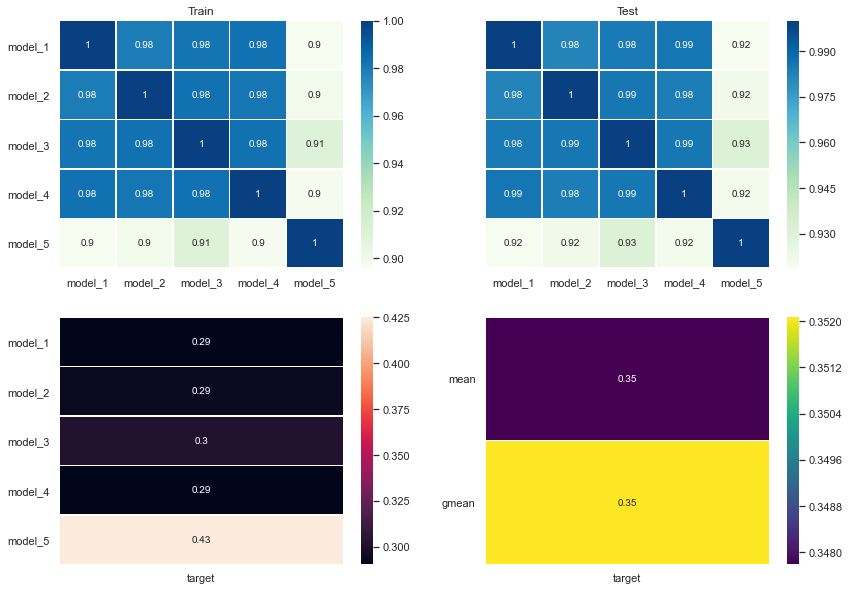

In [23]:
show_corr(X, y, X_test, xgb_estimators)

Выводы:
 - 4 модели дали очень близкие результаты, имеющие, тем не менее, низкую корреляцию с целевым признаком;
 - 5-я модель, меньше всех коррелирующая с остальными, коррелирует сильнее с целевым признаком;
 - среднее арифметическое и среднее геометрическое предсказаний моделей коррелируют с целевым признаком практически одинаково (среднее арифметическое предпочтительнее, поскольку считается быстрее);
 - есть очень серьёзное проседание метрики на oof-предсказаниях в общем. Это может быть вызвано переобучением модели (максимальная глубина дерева равна 7) - требуется также подбор регуляризационных гиперпараметров. 

## LightGBM

Параметры и преобразование данных для модели:

In [24]:
boost_model = 'LGBM'

params = {
    "eval_metric": "AUC",
    "loss_function": "Logloss",
    "learning_rate": 0.01,
    "thread_count": 6,
    "early_stopping_rounds": EARLY_STOPPING_ROUNDS,
    "n_estimators": N_ITERATIONS,
    "seed": SEED
}

for df in X, X_train, X_valid, X_test:
    df[cat_features] = df[cat_features].astype('category')

Оптимальные значения параметров:

In [25]:
lgb_params_search = BayesianOptimization(
    boost_optimize_params,
    pbounds=pbounds,
    random_state=SEED
)

lgb_params_search.maximize(
    init_points=3, n_iter=5, acq='ei'
)
clear_output(wait=True)

update_params(lgb_params_search)

{'params': {'colsample_bytree': 0.33485016730091965,
            'max_depth': 7.330880728874676,
            'min_child_weights': 302.5519308128884},
 'target': 0.7370553977358308}


Кросс-валидация и метрики oof-предсказаний по фолдам:

In [26]:
lgb_estimators, lgb_oof_preds = boost_cross_validation(
    params=params, X=X, y=y, cv=cv, categorical=cat_features
)

Score by each fold: [0.74408, 0.7239, 0.73078, 0.72965, 0.71469]


Метрика oof-предсказаний в общем:

In [27]:
lgb_oof_score = roc_auc_score(y, lgb_oof_preds)
lgb_oof_score

0.7278589676994449

Корреляции:

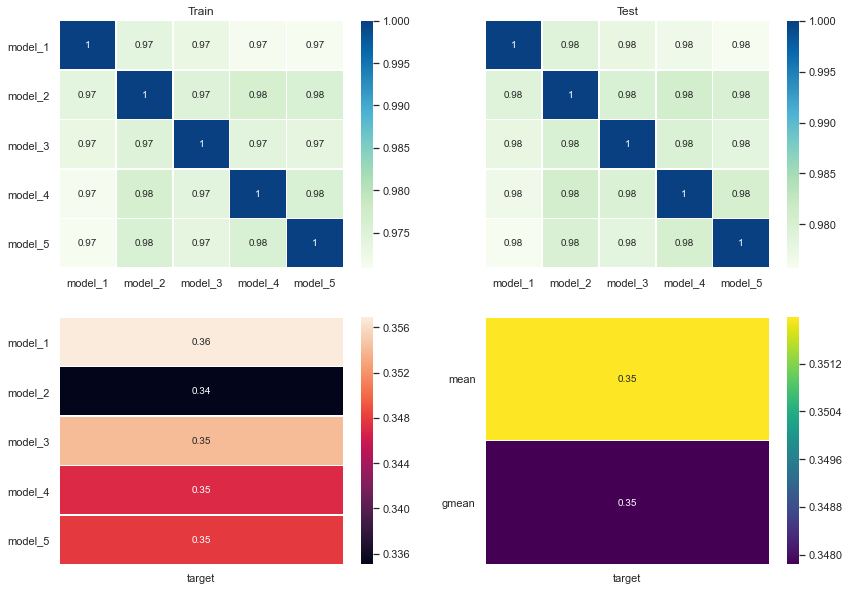

In [28]:
show_corr(X, y, X_test, lgb_estimators)

Выводы:
 - были подобраны те же оптимальные значения гиперпараметров, что и для моделей XGBoost;
 - все модели близко коррелируют друг с другом и практически одинаково - с целевым признаком;
 - среднее арифметическое и среднее геометрическое предсказаний моделей коррелируют также одинаково;
 - метрика oof-предсказаний в общем не выбивается в сравнении с её значениями на отдельных фолдах.

## CatBoost

Параметры и преобразование данных для модели:

In [29]:
boost_model = 'CB'

params = {
    "eval_metric": "AUC",
    "loss_function": "Logloss",
    "learning_rate": 0.01,
    "thread_count": 6,
    "early_stopping_rounds": EARLY_STOPPING_ROUNDS,
    "n_estimators": N_ITERATIONS,
    "random_seed": SEED
}

for df in X, X_train, X_valid, X_test:
    df[cat_features] = df[cat_features].astype('str')
    
cat_features_idx = np.where(X.columns.isin(cat_features))[0]

Функция обучения моделей с заданными параметрами (rsm - Random subspace method):

In [30]:
def cb_optimize_params(max_depth, rsm):

    params["max_depth"] = int(round(max_depth))
    params["rsm"] = rsm
    
    model = CatBoostClassifier(**params)
    model.fit(
        X_train, y_train,
        eval_set=[(X_train, y_train), (X_valid, y_valid)],        
        verbose=VERBOSE,
        cat_features=cat_features_idx
    )

    return roc_auc_score(y_valid, model.predict_proba(X_valid)[:, 1])

In [31]:
pbounds = {
    "max_depth": (3, 8),
    "rsm": (0.3, 0.9)
}

cb_params_search = BayesianOptimization(
    cb_optimize_params,
    pbounds=pbounds,
    random_state=SEED
)

Оптимальные значения параметров:

In [32]:
cb_params_search.maximize(
    init_points=3, n_iter=5, acq='ei'
)
clear_output(wait=True)

update_params(cb_params_search)

{'params': {'max_depth': 6.140745804820556, 'rsm': 0.30124133486060395},
 'target': 0.7314994321502377}


Кросс-валидация и метрики oof-предсказаний по фолдам:

In [33]:
cb_estimators, cb_oof_preds = boost_cross_validation(
    params=params, X=X, y=y, cv=cv, categorical=cat_features_idx
)

Score by each fold: [0.71975, 0.71971, 0.72499, 0.70548, 0.69352]


Метрика oof-предсказаний в общем:

In [34]:
cb_oof_score = roc_auc_score(y, cb_oof_preds)
cb_oof_score

0.6164309638115127

Корреляции:

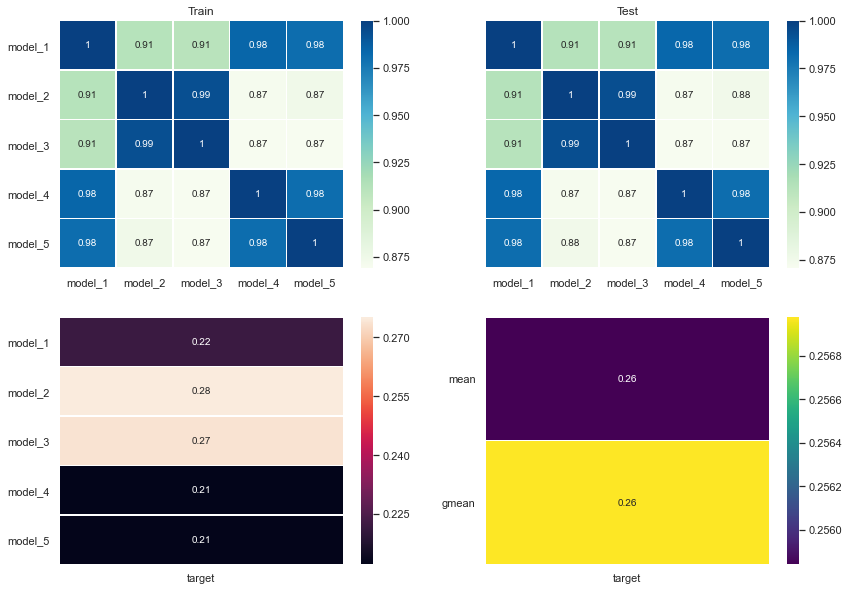

In [35]:
show_corr(X, y, X_test, cb_estimators)

Выводы:
 - сильно коррелируют друг с другом 2-я и 3-я модели, а также 1-я, 4-я и 5-я;
 - с целевым признаком все они коррелируют слабо;
 - снижение метрики oof-предсказаний в общем сигнализирует, как и в случае XGBoost, о возможном переобучении и необходимости регуляризации.

## Логистическая регрессия

In [36]:
oof = pd.DataFrame({'xgb': xgb_oof_preds, 'lgb': lgb_oof_preds, 'cb': cb_oof_preds, 'target': y})
oof.head()

,xgb,lgb,cb,target
0,0.119775,0.017807,0.023856,0.0
1,0.247399,0.084479,0.084740,1.0
2,0.063247,0.060931,0.294433,0.0
3,0.311711,0.167547,0.237750,1.0
4,0.170530,0.083104,0.083315,1.0


In [37]:
logit = LogisticRegressionCV(cv=5, random_state=SEED)
logit.fit(oof[['xgb', 'lgb', 'cb']], oof['target'])

LogisticRegressionCV(Cs=10, class_weight=None, cv=5, dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=100, multi_class='auto', n_jobs=None,
                     penalty='l2', random_state=42, refit=True, scoring=None,
                     solver='lbfgs', tol=0.0001, verbose=0)

In [38]:
pd.DataFrame(
    {'logit_weight': logit.coef_.ravel(),
     'oof_score': [xgb_oof_score, lgb_oof_score, cb_oof_score]},
    index=['xgb', 'lgb','cb'])

,logit_weight,oof_score
xgb,1.417249,0.631875
lgb,5.559575,0.727859
cb,1.398940,0.616431


Логистическая регрессия дала больший вес oof-предсказаниям моделей LightGBM (дополнительное подтверждение корреляциям).

## Общие выводы:
 - в примерно одинаковых условиях модели LightGBM дали лучший результат, чем остальные;
 - улучшение результата XGBoost и CatBoost может быть дрстигнуто в том числе с помощью подбора регуляризующих гиперпараметров; также можно вернуть int(max_depth) для дополнительного сдерживания глубины дерева.